### exp: eqtl prediction, sign prediction, onehot for machine learning

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Esophagus_Mucosa'
data_path = '../../../../../datasets_embedding/onehot/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_seed1030/'
# set seed
seed = 1030
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [4]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

        phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.160584   
1  ENSG00000224387.1   chr1_2493455_T_C_b38           197  0.270073   
2  ENSG00000235241.1  chr1_16889585_T_C_b38           490  0.244526   
3  ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.106880   
4  ENSG00000218510.6  chr1_22025454_G_T_b38           923  0.207521   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        123      132  9.459473e-20  0.291594  0.030113      1   
1        192      222  4.712999e-24  0.487753  0.044613      1   
2        190      201  1.591893e-31  0.884643  0.068237      1   
3         82       87  8.911781e-33  0.500833  0.037676      1   
4        127      149  5.254031e-30  0.611722  0.048697      1   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  GGCACAGCTGACACCGCAGGAGAGCTCGAGGAACATGCCCTGTGCA...   
2  ggcct

In [5]:
print(train_data['label'].unique())

[0 1]


##### model 1: xgboost

In [6]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)

gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5)
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 74}
{'max_depth': 4}


accuracy:0.5106382978723404
precision:0.45161290322580644
recall:0.7
f1-score:0.5490196078431373


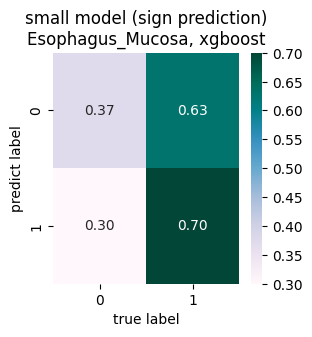

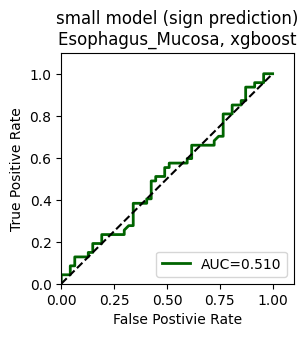

In [7]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 14}


[LightGBM] [Info] Number of positive: 181, number of negative: 201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.324243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32016
[LightGBM] [Info] Number of data points in the train set: 382, number of used features: 16008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473822 -> initscore=-0.104808
[LightGBM] [Info] Start training from score -0.104808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

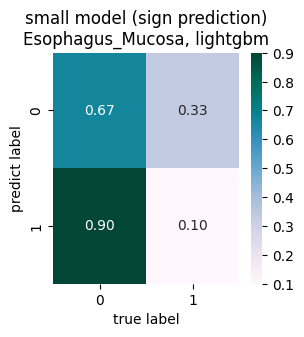

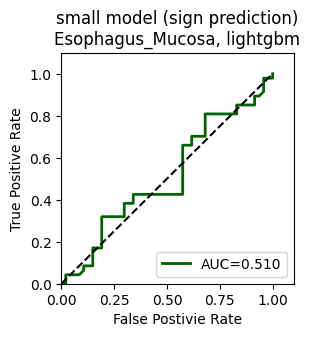

In [9]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 178}
{'max_depth': 9}


accuracy:0.5531914893617021
precision:0.0
recall:0.0
f1-score:0.0


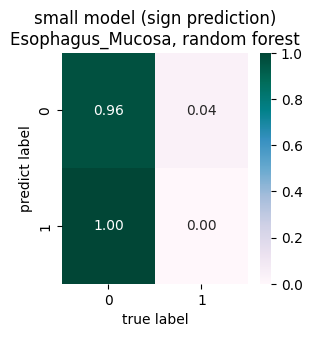

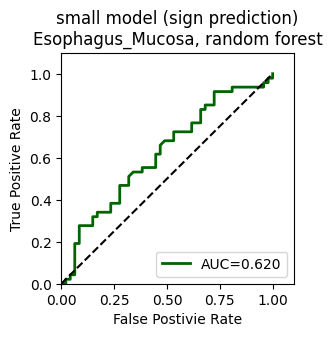

In [11]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 300}

accuracy:0.574468085106383
precision:0.0
recall:0.0
f1-score:0.0


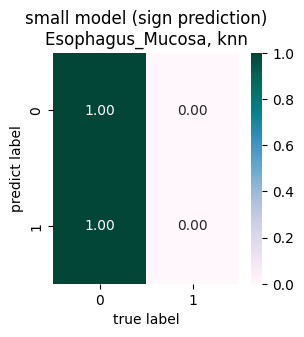

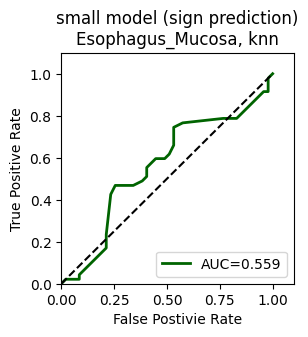

In [13]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.1}
{'C': 1}


accuracy:0.574468085106383
precision:0.0
recall:0.0
f1-score:0.0


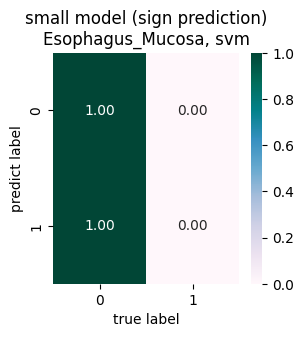

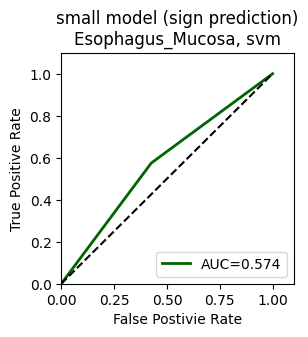

In [15]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [16]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0  ENSG00000187961.13   chr1_959193_G_A_b38         -1394  0.087591   
1   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.452926   
2  ENSG00000178821.12  chr1_1925307_C_A_b38          6034  0.496231   
3   ENSG00000229393.1  chr1_2493455_T_C_b38         -1024  0.270073   
4  ENSG00000116213.15  chr1_3654319_C_T_b38          1558  0.492701   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0         69       72  1.511788e-20  0.456110  0.045976      1   
1        296      373  7.933526e-38  0.651714  0.044649      1   
2        319      408  1.560427e-29  0.608696  0.048948      1   
3        192      222  3.880312e-28  0.540057  0.044780      1   
4        307      405  8.474306e-53  0.511822  0.027893      1   

                                          seq_before  \
0  ACACCTGCAGGCACACAGGCATTCATGGATACACGTGCATACACAC...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  cgtgg

##### model 1: xgboost

In [17]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 10}
{'max_depth': 4}


accuracy:0.41379310344827586
precision:0.6086956521739131
recall:0.358974358974359
f1-score:0.45161290322580644


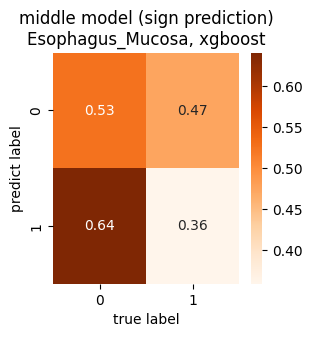

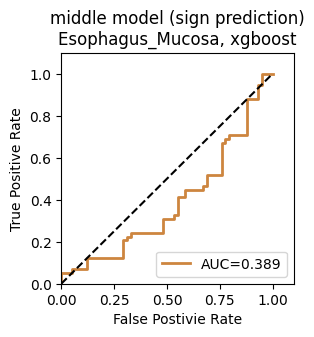

In [18]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [19]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 26}


[LightGBM] [Info] Number of positive: 230, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.681835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320016
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 160008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498915 -> initscore=-0.004338
[LightGBM] [Info] Start training from score -0.004338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

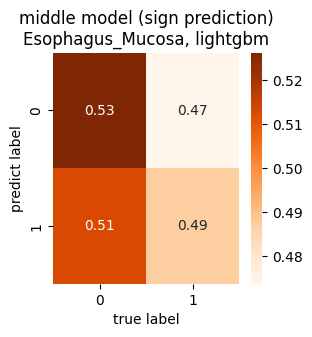

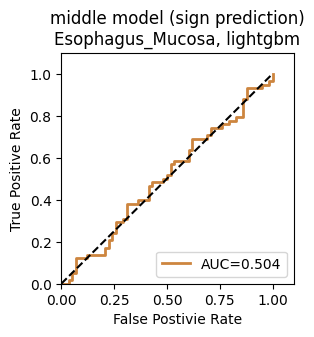

In [20]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 200}
{'max_depth': 5}


accuracy:0.5344827586206896
precision:0.7142857142857143
recall:0.5128205128205128
f1-score:0.5970149253731343


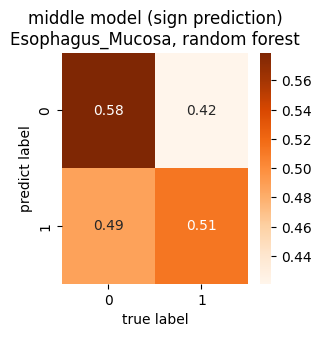

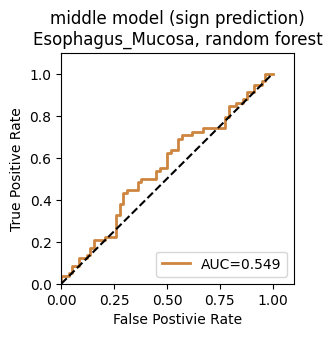

In [22]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

accuracy:0.5172413793103449
precision:0.6896551724137931
recall:0.5128205128205128
f1-score:0.5882352941176471


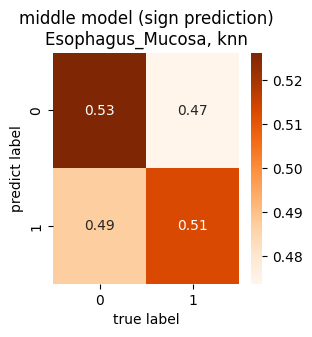

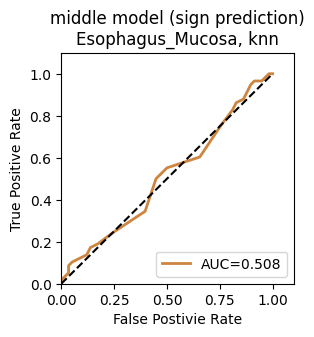

In [24]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.0001}
{'C': 1}


accuracy:0.5517241379310345
precision:0.6756756756756757
recall:0.6410256410256411
f1-score:0.6578947368421053


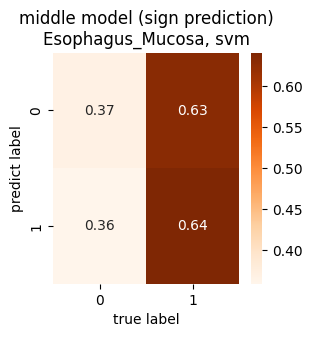

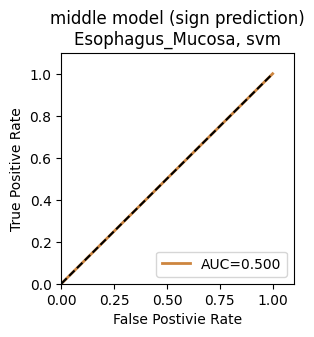

In [26]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [4]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000228794.8   chr1_841166_A_G_b38         16028  0.255474   
1  ENSG00000131591.17  chr1_1091327_C_A_b38        -25034  0.413625   
2   ENSG00000269737.2  chr1_1655861_G_A_b38        -16129  0.030414   
3   ENSG00000224387.1  chr1_2522989_T_C_b38         29731  0.227901   
4   ENSG00000229393.1  chr1_2522989_T_C_b38         28510  0.227901   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        184      210  1.305799e-11  0.291182  0.041555      1   
1        274      340  3.169983e-21  0.223220  0.022056      1   
2         25       25  1.190742e-40  1.664350  0.108687      1   
3        148      165  2.671812e-15  0.454298  0.054812      1   
4        148      165  5.657427e-18  0.507771  0.055545      1   

                                          seq_before  \
0  ctgcaacctcttcccgccgggttcacgccattctcctgcctcagcc...   
1  taatttttgtatttttagtagagatggggtttcatcatgttggcca...   
2  tttca

##### model 1: xgboost

In [5]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 300}
{'max_depth': 4}


accuracy:0.5263157894736842
precision:0.4878048780487805
recall:0.5714285714285714
f1-score:0.5263157894736842


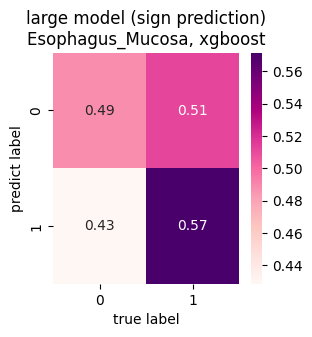

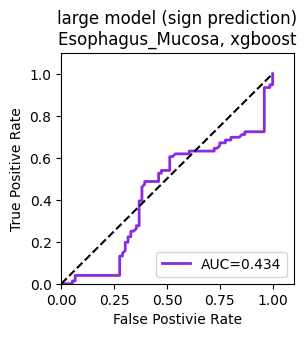

In [6]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [11]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 11}
{'num_leaves': 14}


accuracy:0.4868421052631579
precision:0.4523809523809524
recall:0.5428571428571428
f1-score:0.49350649350649345


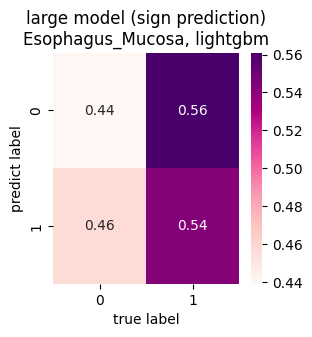

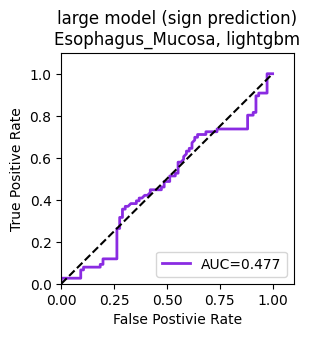

In [12]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 52}
{'max_depth': 7}


accuracy:0.42105263157894735
precision:0.42105263157894735
recall:0.6857142857142857
f1-score:0.5217391304347826


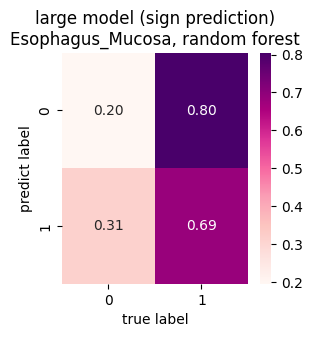

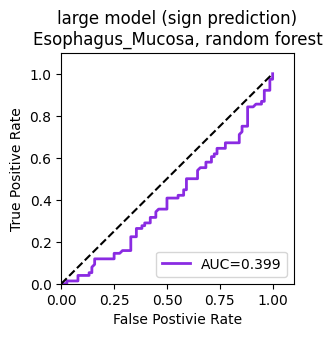

In [6]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

accuracy:0.4473684210526316
precision:0.4426229508196721
recall:0.7714285714285715
f1-score:0.5625


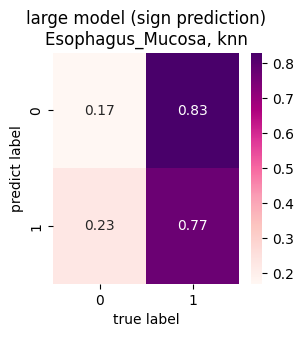

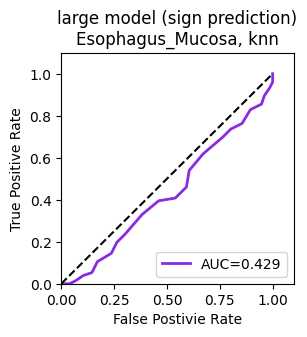

In [8]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 1}
{'C': 10}


accuracy:0.4605263157894737
precision:0.4605263157894737
recall:1.0
f1-score:0.6306306306306306


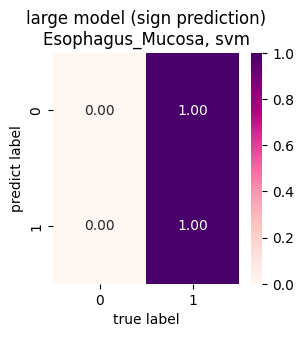

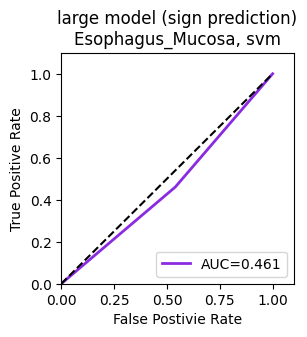

In [10]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()